# **The Chaotic Chef's Quest for the Perfect Meal**

## Project Overview


This project models a reinforcement learning scenario where an agent takes the role of a chef searching city markets for the best ingredients to create dishes from a cookbook. The environment is represented as a 5×5 grid, with each market cell selling a distinct ingredient. The chef moves across the grid, collecting ingredients and facing the challenge of deciding when to stop gathering and attempt to cook.

The success of a dish depends on the recipe: certain ingredient combinations yield high rewards, while incompatible mixes result in penalties. The agent must therefore balance exploration and exploitation, aiming to maximize the final dish value while avoiding unnecessary movements and wasted ingredients.

A budget constraint is introduced and in this extended version, each ingredient has a purchase cost and each dish generates revenue depending on its quality. The objective is no longer just to cook a good meal, but to maximize the chef’s total wealth after several rounds, integrating both resource management and strategic decision-making into the learning process.



## **Agents**

### **Tabular Q-learning (`QLearningAgent`)**

The Q-learning update rule is $Q(s,a) \leftarrow Q(s,a) + \eta[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$

Where:
- $\alpha$ = learning rate
- $\gamma$ = discount factor (0.99)
- $r$ = reward
- $s, a$ = current state and action
- $s', a'$ = next state and action


### **Approximate Q-learning (`ApproxQLearningAgent`)**

$$Q(s,a; \theta) = \text{MLP}_\theta(\text{featurize}(s))_a$$

**TD Update (online learning):**

$$\theta \leftarrow \theta - \alpha \nabla_\theta \left[Q(s,a;\theta) - (r + \gamma \max_{a'} Q(s',a';\theta))\right]^2$$

Where:
- $\theta$ = neural network parameters
- Loss = MSE of TD target
- Optimizer = Adam
- featurize(s) = one-hot position + bag counts + steps left


# **Tabular Q-Learning vs. Approximate Q-Learning**


In this project, we compare two reinforcement learning approaches for an agent tasked with collecting ingredients and cooking dishes in a 5×5 city market grid. The agent must balance **ingredient collection**, **recipe synergies**, and **budget constraints** to maximize wealth.



##  **Tabular Q-Learning Agent**

### Theoretical Overview
- **Algorithm**: Standard off-policy TD control (Q-Learning) with epsilon-greedy exploration.
- **State Representation**: Discrete tuple `(position_x, position_y, steps_left, budget_bin, basket_vector)`.
- **Action Space**: Move {up, down, left, right} or stop and cook.
- **Update Rule**:  
$$
Q(s,a) \gets Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]
$$
- **Convergence**: Guaranteed for finite MDPs with sufficient exploration and decaying learning rate.
- **State Explosion**:
  - 5×5 positions = 25
  - 16 ingredients → 2¹⁶ = 65,536 possible baskets
  - Budget discretized into ~30 levels
  - Total possible states ≈ 49 million
  - Q-values ≈ 49 milion x 6 possible actions


##  **Approximate Q-Learning Agent**

- **Algorithm**: Neural approximate Q-learning (online TD(0)) with epsilon-greedy exploration.
- **State Features**:
  - Grid position one-hot encoding (25 features)
  - Basket presence (16 features)
  - Steps left, normalized
  - Budget ratio, normalized
- **Q-function**: Multi-layer perceptron mapping features → Q-values per action
- **Update Rule**:  
$$
Q(s,a;\theta) \approx r + \gamma \max_{a'} Q(s',a'; \theta)
$$
- **Convergence**: Semi-gradient TD methods converge to a projected fixed point in feature space. May diverge off-policy.


#### **State Representation**

*   **Tabular Q-Learning Agent (`QLearningAgent`)**: This agent uses the `flatten_observation` function, which converts the observation dictionary into a discrete tuple. This creates a unique entry in the Q-table for every possible combination of agent position, binned steps left, binned budget ratio (in the BudgetChef variant), and the binary bag vector.

*   **Approximate Q-Learning Agent (`ApproxQLearningAgent`)**: This agent uses the `featurize` function, which transforms the observation into a continuous feature vector. The MLP then approximates the Q-values based on these features.



In [19]:
from envs import ChaoticChef, BudgetChef
import agents
import metrics
import gymnasium as gym
from tqdm.auto import tqdm
import numpy as np

In [20]:
def train_agent(agent, env, num_episodes, agent_name):
    for ep in tqdm(range(num_episodes)):
        obs, _ = env.reset()

        # Log epsilon at the start of the episode (reflects decay from previous episode)
        agent.logs["epsilons"].append(agent.epsilon)

        done = False
        episode_reward = 0
        episode_length = 0
        truncated = False
        last_reward = 0

        while not done:
            action = agent.select_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            episode_length += 1
            episode_reward += reward
            last_reward = reward

            done = terminated or truncated

            agent.update(obs, action, reward, next_obs, done)

            obs = next_obs

        # Apply epsilon decay at the end of each episode
        agent.epsilon = max(agent.epsilon_min, agent.epsilon - agent.epsilon_decay)

        # Log other episode statistics after the episode finishes
        agent.logs["episode_lengths"].append(episode_length)
        agent.logs["episode_rewards"].append(episode_reward)
        agent.logs["truncated"].append(truncated)
        agent.logs["final_cooking_rewards"].append(last_reward)


    # Print last episode log
    print(
        f"Episode {num_episodes} | Epsilon = {agent.logs['epsilons'][-1]:.3f} | Steps = {agent.logs['episode_lengths'][-1]} | "
        f"Reward = {agent.logs['episode_rewards'][-1]:.2f} | "
        f"Truncated = {agent.logs['truncated'][-1]} | Cooking Reward = {agent.logs['final_cooking_rewards'][-1]:.2f}"
    )


## **The `ChaoticChef` environment**

In this environment, the agent plays as a chef navigating a 5×5 city grid, where each cell represents a market selling a specific ingredient. The chef must move around the grid to collect ingredients and then decide when to stop exploring and attempt to cook a dish. The value of the dish depends on the recipe: certain combinations of ingredients yield high rewards, while incompatible ones result in penalties. The goal is to maximize the total dish value while minimizing wasted ingredients.




**States**

A state is represented as a tuple containing:
- `position`: the chef’s coordinates \((row, col)\) on the 5×5 grid  
- `bag`: the set of collected ingredients and their counts  
- `steps_left`: how many actions remain before the episode ends
- `grid`: grid holds the ingredient index for each cell, flattened

Formally:
\[
S = \{ (pos, bag, steps\_left) \}
\]




**Actions**

`0`: Move left

`1`: Move down

`2`: Move right

`3`: Move up

`4`: Cook (stop exploring and attempt to prepare a dish)

**Rewards**

The recipe score is computed in the `_cook_and_score()` function, which iterates through all available recipes in `self.recipes`.

For each recipe, it calculates:
- **Common**: ingredients that overlap with the recipe.  
- **Waste**: collected ingredients that are not part of the recipe.  

The scoring logic works in two different modes:

1. **Complete recipe** (when all required ingredients are present):

   $$
   \text{score} = (1.5 \times \text{multiplier}) - \big(0.1 \times \sqrt{\text{waste count}}\big)
   $$  

   - Rewards are high for full recipes.  
   - Extra/wrong ingredients are slightly penalized (square root penalty grows slowly).  

2. **Partial recipe (≥75% complete)**:  
   $$
   \text{score} = \left(\frac{\text{common}}{\text{recipe size}}\right) \times \text{multiplier} \times 0.5
   $$  

Partial matches are rewarded but only near-complete recipes (≥75%) are considered valid.  

If no complete recipe is found, any positive score is reduced slightly by `-0.2`.  

Additionally:  
- Starting baseline is a small penalty (`-0.2`).  
- If too few ingredients are collected (<2), the score is fixed at `-1.0`.  
- The best recipe name (or `"Failed Dish"`) is stored in `self.best_recipe`.   


**Transitions**

The transition probability

$$
P(s' \mid s, a)
$$

is deterministic given the action:

- If $a \in \{move\}$, the agent’s position updates, and if a new ingredient is collected, the bag is updated.
- If $a = cook$, the episode terminates, and a final reward is computed.


In [21]:
# Train Agents on ChaoticChef env

print("Training Agents on ChaoticChef: ")

chaotic_env = gym.make("ChaoticChef-v0", grid_size=5, max_steps=100, verbose=False)

episodes = 100000
initial_epsilon = 1.0
chaotic_epsilon_min = 0.2
chaotic_epsilon_decay = (1.0 - 0.2) / 50000

# Need to use the action space and feature dimension specific to ChaoticChef
ql_agent_chaotic = agents.QLearningAgent(
    action_space_n=chaotic_env.action_space.n,
    epsilon=initial_epsilon,
    epsilon_min=chaotic_epsilon_min,
    epsilon_decay=chaotic_epsilon_decay
)

# Calculate feature dimension for ChaoticChef (no budget_ratio)
chaotic_feature_dim = agents.featurize(chaotic_env.observation_space.sample()).size

approx_ql_agent_chaotic = agents.ApproxQLearningAgent(
    action_space_n=chaotic_env.action_space.n,
    feature_dim=chaotic_feature_dim,
    epsilon=initial_epsilon,
    epsilon_min=chaotic_epsilon_min,
    epsilon_decay=chaotic_epsilon_decay
)

# Train agents on ChaoticChef
train_agent(ql_agent_chaotic, chaotic_env, episodes, "QLearningAgent on ChaoticChef")
train_agent(approx_ql_agent_chaotic, chaotic_env, episodes, "ApproxQLearningAgent on ChaoticChef")


Training Agents on ChaoticChef: 


  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.200 | Steps = 20 | Reward = -0.40 | Truncated = False | Cooking Reward = -0.21


  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.200 | Steps = 26 | Reward = -0.46 | Truncated = False | Cooking Reward = -0.21


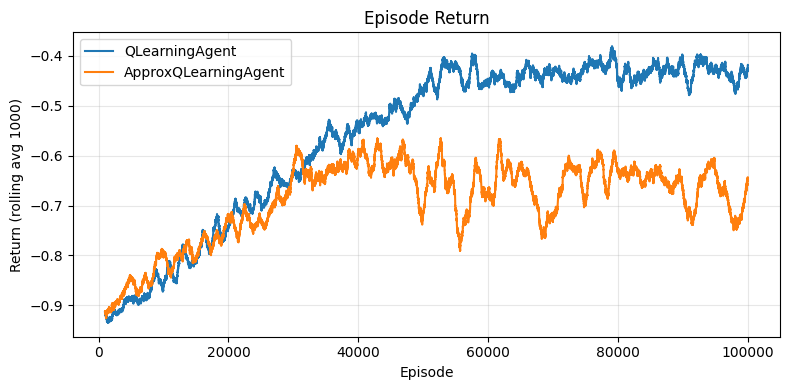

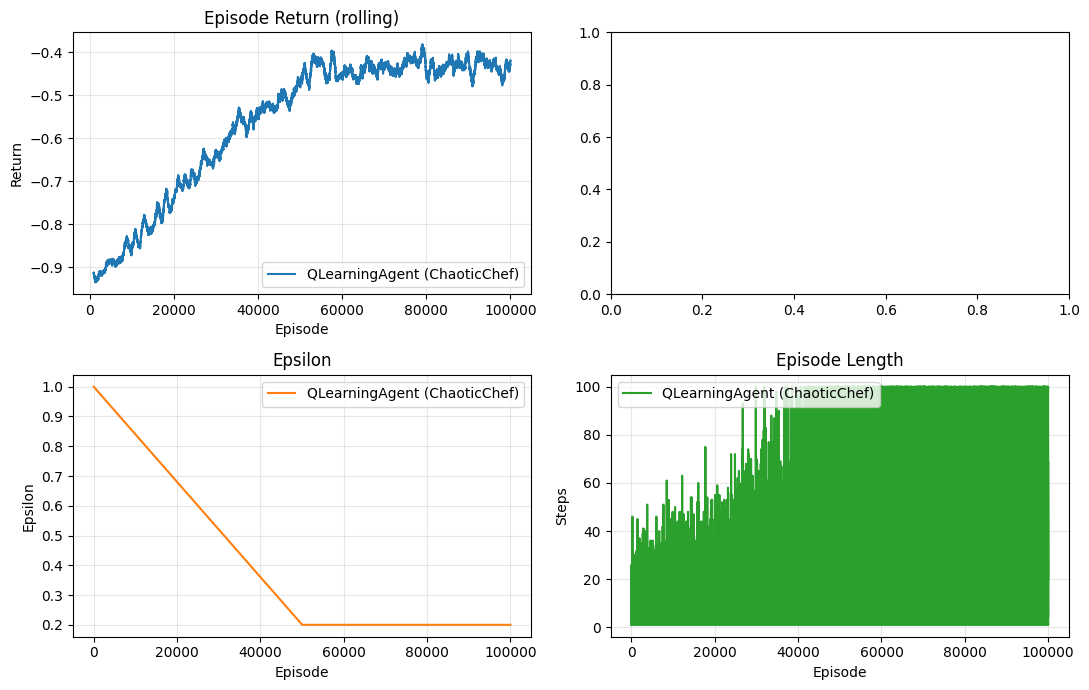

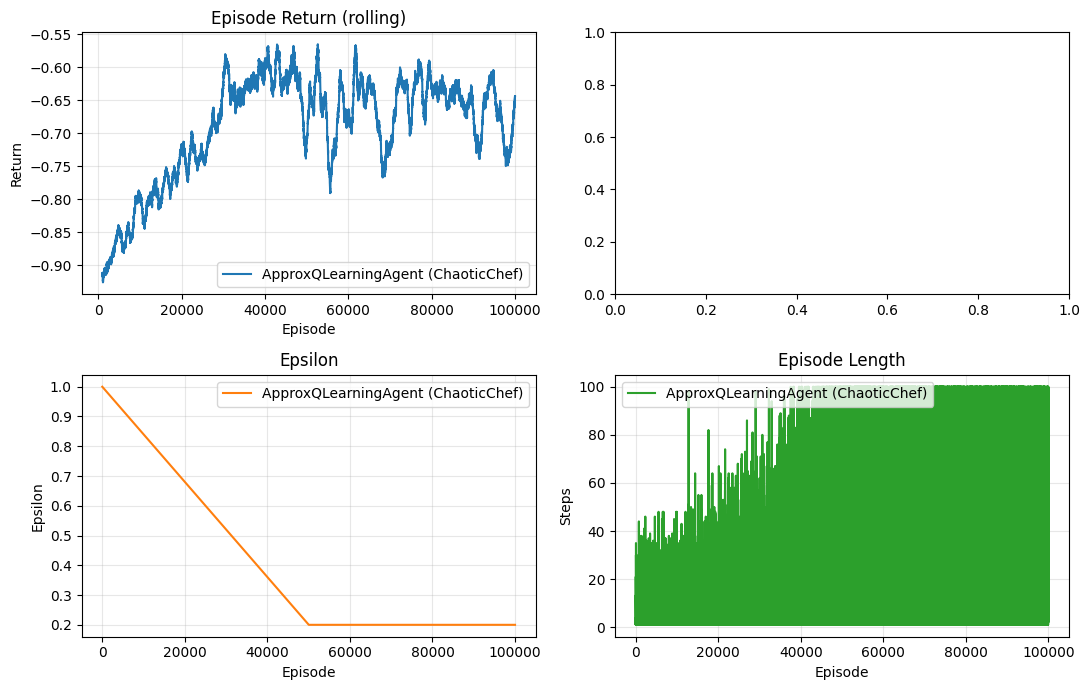

In [22]:
# Plot Learning Curves for ChaoticChef Agents

metrics.plot_returns([ql_agent_chaotic.logs["episode_rewards"], approx_ql_agent_chaotic.logs["episode_rewards"]],
                     ["QLearningAgent", "ApproxQLearningAgent"],
                     window=1000)

# Plot Epsilon Schedules and Episode Lengths for QLearningAgent on ChaoticChef
metrics.plot_agent_logs(ql_agent_chaotic.logs, label="QLearningAgent (ChaoticChef)")

# Plot Epsilon Schedules and Episode Lengths for ApproxQLearningAgent on ChaoticChef
metrics.plot_agent_logs(approx_ql_agent_chaotic.logs, label="ApproxQLearningAgent (ChaoticChef)")

### **ChaoticChef environment performance**



Both agents were trained for 100,000 episodes with epsilon decaying linearly from 1.0 to 0.2 over 50,000 episodes.

#### **Episode Return Performance**

 The QLearningAgent is demonstrating superior learning throughout the entire training process, improving from an initial return of approximately -0.90 to a stable **final performance of -0.40** to -0.45 by episode 50,000. This represents more than a 100% improvement in returns.

The ApproxQLearningAgent follows a similar initial trajectory, improving from -0.90 to approximately -0.70 during the first 30,000 episodes and tracking the tabular agent reasonably well. However, around episode 30,000, the two agents' performance begins to diverge noticeably. While the tabular agent continues improving to -0.45, **the neural network agent reaches -0.65** and remains there for the duration of training. This creates a persistent performance gap, with **the tabular agent achieving roughly 40% better performance than the neural network agent** in relative terms.


####**Episode Length Patterns**


The fact that both agents survive for the full 100 steps while achieving different returns indicates that the performance gap is about action quality during those steps. The **QLearningAgent accumulates less negative reward per step**, suggesting it makes more efficient decisions about ingredient collection, movement patterns, or cooking actions. The ApproxQLearningAgent, despite living just as long, makes choices that result in **50% more negative reward accumulation** over the same number of steps.

#### **Epsilon Decay and Exploration**


Interestingly, the performance gap emerges and stabilizes well before epsilon reaches its minimum at episode 50,000. By episode 30,000, when epsilon is still around 0.5, the divergence between agents is already apparent. This suggests that **the performance difference is not primarily about exploration strategy but about representational capacity**: the tabular agent leverages exploration to learn precise state-specific policies, while the neural network's exploration generalizes approximation that cannot capture the same level of detail.













## **The `BudgetChef` environment**

In this variant, the agent still plays as a chef navigating the 5×5 city grid of markets, but now a **monetary budget** is introduced. Each ingredient has a purchase cost, and each cooked dish generates revenue depending on its quality. The challenge is no longer just to maximize dish value, but to  **maximize the chef’s total wealth** after a sequence of episodes.

An episode ends when one of the following occurs:
- The agent chooses the **Cook** action  
- The maximum number of steps is reached  
- The budget is fully exhausted (no further actions possible)

**State Space**

The observation includes:
- `position`: the chef’s current coordinates `(row, col)` on the grid  
- `bag`: the inventory of collected ingredients (with counts)  
- `steps_left`: how many moves remain before the episode ends
- `grid`: grid holds the ingredient index for each cell, flattened

- `budget_ratio`: the remaining budget divided by the initial budget  




**Actions**

`0`: Move left  
`1`: Move down  
`2`: Move right  
`3`: Move up  
`4`: Cook (stop exploring and attempt to prepare a dish)  


**Rewards**

In addition to the recipe score defined in `_cook_and_score()`, BudgetChef modifies the reward function to incorporate **costs and revenues**:

When the agent chooses `cook`, the revenue is computed as:

$$
\text{Revenue} = \max(0, R_{\text{dish}} \times m)
$$

Where:  

- $R_{\text{dish}}$ = score from `_cook_and_score()`, determined by the ingredients collected and the recipe matched  
- $m$ = `revenue_multiplier` (scaling factor, default = 1.0)

The **budget after cooking** is updated as:

$$
\text{Budget}_{\text{after cook}} = \text{Budget}_{\text{before cook}} + \text{Revenue}
$$



**Transitions**

Transitions are deterministic given the chosen action:
- Movement actions update the `position` and, if applicable, add an ingredient to the bag while reducing the budget.  
- The `Cook` action ends the episode and computes the recipe reward plus revenue.  




In [ ]:
# Parameters
grid_size = 5
max_steps = 100
episodes = 100000
start_budget = 30


# Epsilon parameters
initial_epsilon = 1.0
epsilon_min = 0.02
epsilon_decay = (1.0 - 0.02) / 50000

# Instantiate environment and agents
budget_env = gym.make("BudgetChef-v0", grid_size=grid_size, max_steps=max_steps, start_budget=start_budget, verbose=False)

ql_agent = agents.QLearningAgent(
    action_space_n=budget_env.action_space.n,
    epsilon=initial_epsilon,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay
)

approx_ql_agent = agents.ApproxQLearningAgent(
    action_space_n=budget_env.action_space.n,
    feature_dim=agents.featurize(budget_env.observation_space.sample()).size,
    epsilon=initial_epsilon,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay
)

# Train agents on BudgetChef
train_agent(ql_agent, budget_env, episodes, "QLearningAgent")
train_agent(approx_ql_agent, budget_env, episodes, "ApproxQLearningAgent")

  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.020 | Steps = 13 | Reward = -0.83 | Truncated = False | Cooking Reward = -0.21


  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.020 | Steps = 5 | Reward = -0.25 | Truncated = False | Cooking Reward = -0.21


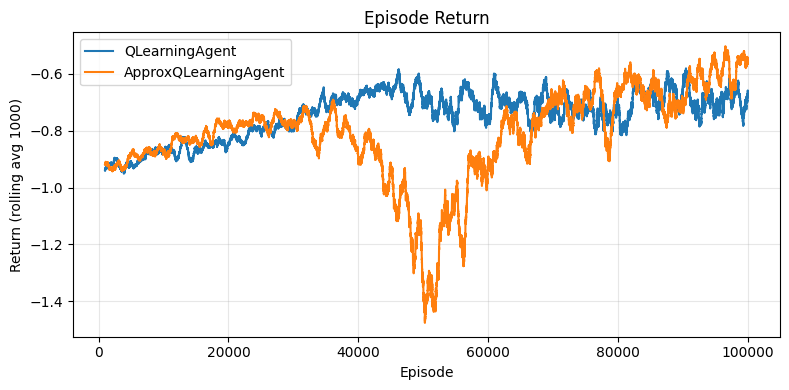

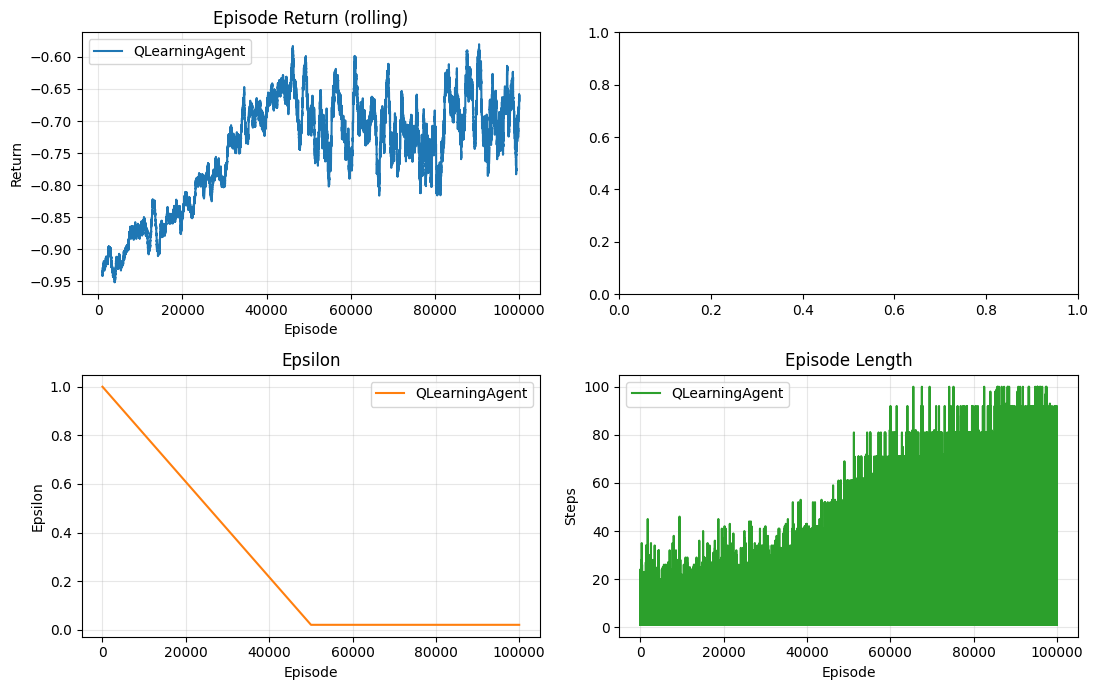

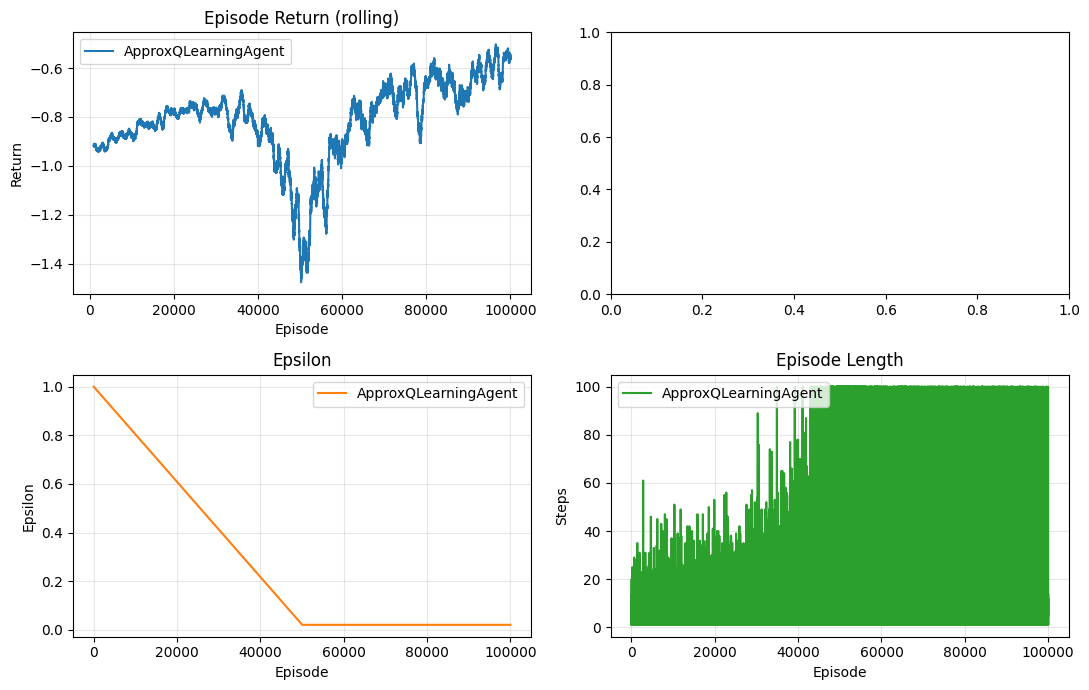

In [ ]:
# Plot Learning Curves
metrics.plot_returns([ql_agent.logs["episode_rewards"], approx_ql_agent.logs["episode_rewards"]],
                     ["QLearningAgent", "ApproxQLearningAgent"],
                     window=1000)

# Plot Epsilon Schedules and Episode Lengths for QLearningAgent
metrics.plot_agent_logs(ql_agent.logs, label="QLearningAgent")

# Plot Epsilon Schedules and Episode Lengths for ApproxQLearningAgent
metrics.plot_agent_logs(approx_ql_agent.logs, label="ApproxQLearningAgent")

### **BudgetChef agent Analysis**



Both agents were trained for 100,000 episodes with epsilon decaying linearly from 1.0 to 0.02 over 50,000 episodes.

#### **Episode returns**
The episode return curves reveal that both agents achieve similar final performance, converging to approximately -0.65 to -0.75 average returns. The QLearningAgent demonstrates a more stable learning throughout the training process, with a smooth **improvement from -0.90 to around -0.70** by episode 40,000, followed by consistent performance with moderate variance of approximately ±0.10 for the remainder of training.

The ApproxQLearningAgent follows a nearly identical trajectory during the initial 40,000 episodes, achieving similar returns around -0.80. However, between episodes 45,000 and 55,000, the neural network agent experiences a significant performance drop to approximately -1.85. Then recovers over the subsequent 15,000 episodes, gradually **improving back to -0.80** and maintaining performance comparable to the tabular agent through the final 30,000 episodes.

The ApproxQLearningAgent incorporated several stability improvements including a target network updated every 1000 gradient steps, experience replay with random sampling from a 20,000-transition buffer, gradient clipping, and a learning rate of 1e-4. Network updates were performed every 4 steps rather than every step to reduce training instability.


#### **Episode Length**

The QLearningAgent shows progression from short episodes of 20-40 steps in early training to consistently reaching near-maximum episode lengths of 80-100 steps by episode 60,000. This pattern indicates the agent is learning to avoid premature termination as the **gradual increase in episode length correlates with improving returns**.

The ApproxQLearningAgent displays a similar but more volatile pattern. Early episodes range from 30-60 steps with high variance, gradually increasing to approach the maximum 100 steps by episode 40,000. However, during the performance collapse around episode 50,000, episode lengths temporarily drop to 60-80 steps before recovering. The correlation between the return collapse and shorter episode lengths confirms that **early termination is due to running out of budget or geting stuck**




#### **Epsilon Decay and Exploration**

The timing of the ApproxQLearningAgent's collapse around episode 50,000 is notable because it coincides with epsilon reaching its minimum value. This suggests that **reduced exploration may have contributed to the instability**.

The recovery despite minimal exploration after episode 50,000 indicates that the replay buffer retained enough diverse historical experiences to eventually pull the agent back toward better policies.









In [ ]:
#ql_agent

print("Running a single verbose evaluation episode (ql_agent): ")
eval_env_verbose = gym.make("BudgetChef-v0", grid_size=5, max_steps=100, start_budget=30, verbose=True)

obs, info = eval_env_verbose.reset()
done = False
episode_reward = 0
steps = 0

# Using the trained QLearningAgent's greedy policy
agent_to_evaluate1 = ql_agent

while not done:
    action = agent_to_evaluate1.greedy_policy(obs)
    next_obs, reward, terminated, truncated, info = eval_env_verbose.step(action)

    episode_reward += reward
    steps += 1
    done = terminated or truncated
    obs = next_obs

print(f"Total Steps: {steps}")
print(f"Total Episode Reward: {episode_reward:.2f}")
print(f"Final Cooking Reward: {reward:.2f}") # Assuming the last reward is cooking reward

Running a single verbose evaluation episode (ql_agent): 

Current position: (np.int64(1), np.int64(4)) (Tomato)
Current budget: 28.00
Action: down (1)
Step: 1
Moved to: (np.int64(2), np.int64(4)) (Wine)
Paid cost: 6, Remaining budget: 22.00
Reward: -0.01

Current position: (np.int64(2), np.int64(4)) (Wine)
Current budget: 22.00
Action: pick (4)
Step: 2
Picked: Wine (cost: 6)
Reward: -0.01

Current position: (np.int64(2), np.int64(4)) (Wine)
Current budget: 16.00
Action: up (0)
Step: 3
Moved to: (np.int64(1), np.int64(4)) (Tomato)
Paid cost: 2, Remaining budget: 14.00
Reward: -0.01

Current position: (np.int64(1), np.int64(4)) (Tomato)
Current budget: 14.00
Action: pick (4)
Step: 4
Picked: Tomato (cost: 2)
Reward: -0.01

Current position: (np.int64(1), np.int64(4)) (Tomato)
Current budget: 12.00
Action: cook (5)
Step: 5
Cooking. Ingredients: ['Tomato', 'Wine']
Best recipe matched: "Failed Dish", Reward: -0.20, Revenue: 0.00
New budget: 12.00
Reward: -0.21000000000000002
Total Steps: 5
T

In [ ]:
#approx_ql_agent

print("Running a single verbose evaluation episode (approx_ql_agent): ")
eval_env_verbose = gym.make("BudgetChef-v0", grid_size=5, max_steps=100, start_budget=30, verbose=True)

obs, info = eval_env_verbose.reset()
done = False
episode_reward = 0
steps = 0

# Using the trained QLearningAgent's greedy policy
agent_to_evaluate2 = approx_ql_agent

while not done:
    action = agent_to_evaluate2.greedy_policy(obs)
    next_obs, reward, terminated, truncated, info = eval_env_verbose.step(action)

    episode_reward += reward
    steps += 1
    done = terminated or truncated
    obs = next_obs

print(f"Total Steps: {steps}")
print(f"Total Episode Reward: {episode_reward:.2f}")
print(f"Final Cooking Reward: {reward:.2f}") # last reward is cooking reward

Running a single verbose evaluation episode (approx_ql_agent): 

Current position: (np.int64(4), np.int64(2)) (Cheese)
Current budget: 25.00
Action: pick (4)
Step: 1
Picked: Cheese (cost: 5)
Reward: -0.01

Current position: (np.int64(4), np.int64(2)) (Cheese)
Current budget: 20.00
Action: right (3)
Step: 2
Moved to: (np.int64(4), np.int64(3)) (Olive Oil)
Paid cost: 3, Remaining budget: 17.00
Reward: -0.01

Current position: (np.int64(4), np.int64(3)) (Olive Oil)
Current budget: 17.00
Action: up (0)
Step: 3
Moved to: (np.int64(3), np.int64(3)) (Truffle)
Paid cost: 15, Remaining budget: 2.00
Reward: -0.01

Current position: (np.int64(3), np.int64(3)) (Truffle)
Current budget: 2.00
Action: left (2)
Step: 4
Cannot afford to move (cost: 6, budget: 2)
Reward: -0.11

Current position: (np.int64(3), np.int64(3)) (Truffle)
Current budget: 2.00
Action: cook (5)
Step: 5
Cooking. Ingredients: ['Cheese']
Best recipe matched: "None", Reward: -1.00, Revenue: 0.00
New budget: 2.00
Reward: -1.01
Total 

In [ ]:
# Evaluate the trained agents' greedy policies

episodes = 100000

print("Evaluating Greedy Policies on BudgetChef env:")

# Evaluate QLearningAgent
ql_final_cooking_rewards = []
ql_episode_rewards = []

for _ in range(episodes):
    obs, _ = budget_env.reset()
    done = False
    episode_reward = 0
    while not done:
        action = ql_agent.greedy_policy(obs)
        next_obs, reward, terminated, truncated, info = budget_env.step(action)
        episode_reward += reward
        done = terminated or truncated
        obs = next_obs
    ql_final_cooking_rewards.append(reward) # Final reward is the cooking reward
    ql_episode_rewards.append(episode_reward)

avg_ql_cooking_reward = np.mean(ql_final_cooking_rewards)
avg_ql_episode_reward = np.mean(ql_episode_rewards)

print(f"\nQLearningAgent (BudgetChef):")
print(f"  Average Final Cooking Reward: {avg_ql_cooking_reward:.2f}")
print(f"  Average Total Episode Reward: {avg_ql_episode_reward:.2f}")

# Evaluate ApproxQLearningAgent
approx_ql_final_cooking_rewards = []
approx_ql_episode_rewards = []

for _ in range(episodes):
    obs, _ = budget_env.reset()
    done = False
    episode_reward = 0
    while not done:
        action = approx_ql_agent.greedy_policy(obs)
        next_obs, reward, terminated, truncated, info = budget_env.step(action)
        episode_reward += reward
        done = terminated or truncated
        obs = next_obs
    approx_ql_final_cooking_rewards.append(reward) # Final reward is the cooking reward
    approx_ql_episode_rewards.append(episode_reward)

avg_approx_ql_cooking_reward = np.mean(approx_ql_final_cooking_rewards)
avg_approx_ql_episode_reward = np.mean(approx_ql_episode_rewards)

print(f"\nApproxQLearningAgent (BudgetChef):")
print(f"  Average Final Cooking Reward: {avg_approx_ql_cooking_reward:.2f}")
print(f"  Average Total Episode Reward: {avg_approx_ql_episode_reward:.2f}")

Evaluating Greedy Policies on BudgetChef env:

QLearningAgent (BudgetChef):
  Average Final Cooking Reward: -0.17
  Average Total Episode Reward: -1.56

ApproxQLearningAgent (BudgetChef):
  Average Final Cooking Reward: -0.27
  Average Total Episode Reward: -0.57


**Analysis of Greedy Policy Evaluation Results**

The greedy policy evaluation tests the agent’s learned policy without exploration (on the `BudgetChef` environment). The greedy policy always selects the action with the highest estimated Q-value for the current state, without any exploration.

The `greedy_policy` method for the QLearningAgent selects the action with the highest Q-value for the current state. If the state is unseen, it picks a random action.

In the ApproxQLearningAgent it uses the neural network to compute Q-values for the current state and selects the action with the highest Q-value (using `q.argmax(dim=1).item()`).


**Comparison:**

Both agents have **negative rewards**, indicating suboptimal policies howerver, the tabular QLearningAgent achieves a higher final cooking reward but a lower total episode reward compared to the ApproxQLearningAgent.
The ApproxQLearningAgent, while having a worse final cooking reward, accumulates a better total episode reward over the episode.


The tabular agent may be better at optimizing for the final state due to its **ability to memorize specific state-action pairs**, but struggles with overall episode management, due to **limited generalization**.

The approximate agent generalizes across states, which can help it **accumulate rewards more consistently** throughout the episode, but does not learn the optimal actions for the final cooking step as precisely.


In [ ]:
# Print Evaluation Results
avg_cooking_rewards = [np.mean(ql_final_cooking_rewards), np.mean(approx_ql_final_cooking_rewards)]
std_cooking_rewards = [np.std(ql_final_cooking_rewards), np.std(approx_ql_final_cooking_rewards)]

avg_episode_rewards = [np.mean(ql_episode_rewards), np.mean(approx_ql_episode_rewards)]
std_episode_rewards = [np.std(ql_episode_rewards), np.std(approx_ql_episode_rewards)] # Corrected variable name


print("\nEvaluation Results:")
print(f"{'Metric':<30} | {'QLearningAgent':<20} | {'ApproxQLearningAgent':<25}")
print("-" * 90)
print(f"{'Average Final Cooking Reward':<30} | {np.mean(ql_final_cooking_rewards):<20.2f} | {np.mean(approx_ql_final_cooking_rewards):<25.2f}")
print(f"{'Std Dev Final Cooking Reward':<30} | {np.std(ql_final_cooking_rewards):<20.2f} | {np.std(approx_ql_final_cooking_rewards):<25.2f}")
print(f"{'Average Total Episode Reward':<30} | {np.mean(ql_episode_rewards):<20.2f} | {np.mean(approx_ql_episode_rewards):<25.2f}")
print(f"{'Std Dev Total Episode Reward':<30} | {np.std(ql_episode_rewards):<20.2f} | {np.std(approx_ql_episode_rewards):<25.2f}")


Evaluation Results:
Metric                         | QLearningAgent       | ApproxQLearningAgent     
------------------------------------------------------------------------------------------
Average Final Cooking Reward   | -0.17                | -0.27                    
Std Dev Final Cooking Reward   | 0.33                 | 0.35                     
Average Total Episode Reward   | -1.56                | -0.57                    
Std Dev Total Episode Reward   | 2.31                 | 1.36                     



### **Conclusion**

In this project, I purpusely designed the environment with a penalty-heavy reward structure. The intention was to punish mistakes strongly so that the agent avoids random collecting. Therefore, scores and revenues become highly sensitive to small differences, just one extra wrong ingredient can lower the outcome. And the agent may learn to focus more on avoiding failure than on actively cooking high-profitable recipes.

In BudgetChef, both agents achieved comparable **final performance around -0.70**, with the neural network requiring more complex stabilization mechanisms but ultimately succeeding. In ChaoticChef, the tabular agent achieves better performance at **-0.42** compared to the neural network's **-0.65**.

The difference between environments performance lies in **how state features relate to optimal actions**. BudgetChef includes a continuous budget dimension that creates natural smoothness in the value function. States with similar budget values should have similar optimal policies because budget level directly and predictably affects what actions are affordable and valuable. The neural network's tendency to generalize across similar states aligns well with this structure of the problem.

ChaoticChef, by contrast, derives its difficulty from stochasticity rather than continuous dimensions. The environment includes random events and variable cooking outcomes that make similar states require different optimal actions. When the neural network generalizes across states with similar grid positions and inventory configurations, it averages over hidden stochastic factors and learns a compromise policy. The tabular agent's treatment of each state as independent allows it to learn the expected optimal action for each specific state configuration under the environment's stochastic distribution.


To conclude, the tabular QLearningAgent's **40% performance advantage** over the ApproxQLearningAgent reflects not a failure of stability mechanisms but an **advantage in representing state-specific policies under stochasticity**.



